In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats
import statsmodels.api as sm

# PROJECT CASE SCENARIO
You are a Data Scientist with a housing agency in Boston MA, you have been given access to a previous dataset on housing prices derived from the U.S Census Service to present insights to higher management. Based on your experience in Statistics, what information can you provide them to help with making an informed decision? Upper management will like to get some insight into the following: 
<li> Is there a significant difference in the median values of houses of each proportion of owner occupied units built before 1940?
<li> Is there a difference in median values of houses of each proportion of owner occupied units built before 1940?
<li> Can we conclude that there is no relationship between Nitric Oxide concentrations and the proportion of non-retail business acres per town?
<li> What is the impact of an additional weighted distance to the five Boston employment centres on the median value of owner-occupied homes?
    
    
Use appropriate visualizations and statistics that you think will be useful for the upper management to give them an insight to the questions they are asking.

In [2]:
#gathering the data
boston_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
df=pd.read_csv(boston_url, index_col=0)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(13)
memory usage: 55.3 KB


The following describes the dataset variables:

·      CRIM - per capita crime rate by town

·      ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

·      INDUS - proportion of non-retail business acres per town.

·      CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

·      NOX - nitric oxides concentration (parts per 10 million)

·      RM - average number of rooms per dwelling

·      AGE - proportion of owner-occupied units built prior to 1940

·      DIS - weighted distances to five Boston employment centres

·      RAD - index of accessibility to radial highways

·      TAX - full-value property-tax rate per $10,000

·      PTRATIO - pupil-teacher ratio by town

·      LSTAT - % lower status of the population

·      MEDV - Median value of owner-occupied homes in $1000's

## QUESTION ONE
### Is there a significant difference in the median value of houses bounded by the Charles river or not?

To evaluate this, we use a T-distribution hypothesis test i.e a t-test. A z-test would not be applicable as the dataset is a sample and not the total population of possible instances.
We assume significance level $\alpha$ = 0.05.

Null Hypothesis H<sub>o</sub>: Both variables have no statistical difference. i.e no difference in median values for houses bounded by the Charles River and those that are not.

Alternate Hypothesis H<sub>a</sub>: There is a statistical difference between variables.

In [4]:
#to separate our dataset into houses bounded by Charles River or not, we need a boolean mask.
chas_mask = df['CHAS'] == 0

# for our ttest,
scipy.stats.ttest_ind(df[chas_mask]['MEDV'], df[~chas_mask]['MEDV'])

Ttest_indResult(statistic=-3.996437466090509, pvalue=7.390623170519905e-05)

The ttest returned a p-value less than 0.05; this means that the null hypothesis can be rejected and the alternate hypothesis is the case. i.e there is a significant difference in the median value of houses bounded by the Charles river or not.

Text(0.5, 0, 'Bounded by Charles river or not')

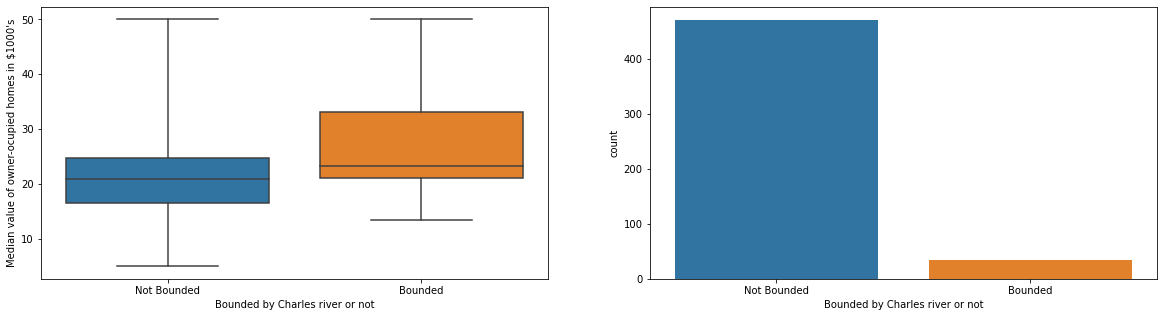

In [5]:
#VISUALIZATION
#To help visualize the ttest's conclusions, let us look at a box plot of the variables.
#let's also view a barplot of the Charles River variable

plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='CHAS', y='MEDV', whis=30)
plt.xticks((0,1), ('Not Bounded', 'Bounded'))
plt.xlabel('Bounded by Charles river or not')
plt.ylabel("Median value of owner-ocupied homes in $1000's")
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='CHAS')
plt.xticks((0,1), ('Not Bounded', 'Bounded'))
plt.xlabel('Bounded by Charles river or not')

## QUESTION TWO
### Is there a difference in median values of houses of each proportion of owner occupied units built before 1940?

To evaluate this, we use a F-distribution hypothesis test i.e ANOVA. ANOVA is used because there is analysis of more than two variables.
We assume significance level $\alpha$ = 0.05.

Null Hypothesis H<sub>o</sub>: ALL variables have no statistical difference. i.e no difference in median values for houses built at any time before 1940.

Alternate Hypothesis H<sub>a</sub>: There is a statistical difference between variables.

In [6]:
#first we dicretize the AGE variable into three groups: 35 and younger, between 35 and 70, 70 and older.
bin_edges = [0.0, 35.0, 70.0, df.AGE.max()]
bin_names = ['35 and younger', 'between 35 and 70', '70 and older']
df['AGE_GROUP'] = pd.cut(df['AGE'], bin_edges, labels=bin_names)
mask_a = df['AGE_GROUP'] == '35 and younger'
mask_b = df['AGE_GROUP'] == 'between 35 and 70'
mask_c = df['AGE_GROUP'] == '70 and older'
#to do the anova statistic,
f_statistic, p_value = scipy.stats.f_oneway(df[mask_a]['MEDV'], df[mask_b]['MEDV'], df[mask_c]['MEDV'])
print(f"F-statistic: {f_statistic}, p_value: {p_value}")

F-statistic: 36.40764999196599, p_value: 1.7105011022702984e-15


Since the p-value is less than our chose value for alpha, we reject the null hypothesis and conclude that there is a statistical difference in median values of houses of each proportion of owner-occupied units built some time before 1940.

<AxesSubplot:xlabel='AGE_GROUP', ylabel='MEDV'>

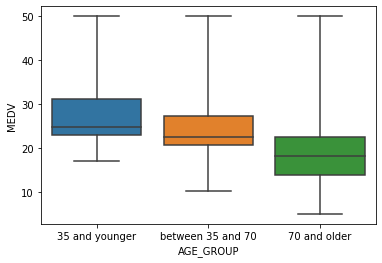

In [7]:
#to visulize the result from the statistical test, we will use a boxplot
sns.boxplot(data = df, x='AGE_GROUP', y='MEDV', whis = 10)

## QUESTION THREE
### Can we conclude that there is no relationship between Nitric Oxide concentrations and the proportion of non-retail business acres per town?

To evaluate this, we use a Pearson correlation test.
We assume significance level $\alpha$ = 0.05.

Null Hypothesis H<sub>o</sub>: There is no association between variables. i.e Nitric oxide concentrations has nothing to do with the proportion of non-retail business acres per town (and vice versa).

Alternate Hypothesis H<sub>a</sub>: There is an association between Nitric Oxide concentrations and proportion of non-retail business acres per town.

In [8]:
coeff, p_value = scipy.stats.pearsonr(df['NOX'], df['INDUS'])
print(f"Pearson correlation coefficient: {coeff}, p-value: {p_value}")

Pearson correlation coefficient: 0.7636514469209161, p-value: 7.913361061230596e-98


A p-value that low means the null hypothesis can be rejected and we can conclude that there is an association between the Nitric Oxide concentrations in the environment and the number of industries in that environment.
A pearson correlation coefficient of 0.763 suggests a strong positive correlation between the variables. In other words, more non-retail businesses will usually result in higher Nitric oxide concentrations.

We can visualize this on a scatter plot.

Text(0, 0.5, 'Nitric oxide concentrations')

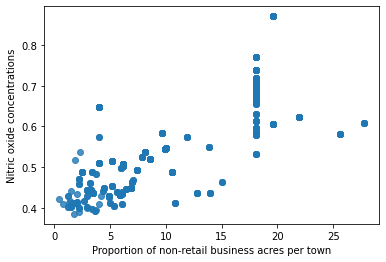

In [9]:
sns.regplot(data = df, x='INDUS', y='NOX', fit_reg=False)
plt.xlabel('Proportion of non-retail business acres per town')
plt.ylabel('Nitric oxide concentrations')

## QUESTION FOUR
### What is the impact of an additional weighted distance to the five Boston employment centres on the median value of owner-occupied homes?

To evaluate this, we use regression analysis.

In [10]:
x = df['DIS'] #independent variable
y = df['MEDV'] #dependent variable

x = sm.add_constant(x) #add constant 
model = sm.OLS(y, x).fit() #create linear regression model and fit to data
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           1.21e-08
Time:                        19:27:16   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3901      0.817     22.499      0.000      16.784      19.996
DIS            1.0916      0.188      5.795      0.000       0.722       1.462
==============================================================================
Omnibus:                      139.779   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.104
Skew:                           1.466   Prob(JB):                     5.59e-67
Kurtosis:                       5.424   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Ordinary Least Squares (OLS) regression model gives the result y = 18.3901 + 1.0916x, where y is the median value of owner occupied homes and x is the weighted distance to the five Boston employment centres.
In simpler terms, when the distance is zero, the median value is \\$18,390.1 and every unit increase in the distance equals a $1,000 increase in the median value.

## DISTRIBUTION PLOT OF PUPIL TO TEACHER RATIO

In [11]:
print(df['PTRATIO'].max(), df['PTRATIO'].min())

22.0 12.6


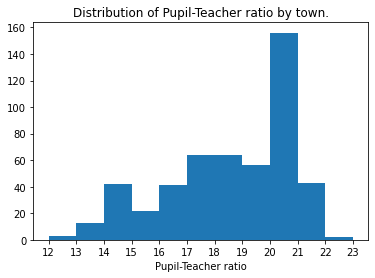

In [12]:
ticks = np.arange(12, 24, 1)
labes = [str(v) for v in ticks]
plt.hist(df['PTRATIO'], bins = ticks)
plt.xticks(ticks, labes)
plt.xlabel('Pupil-Teacher ratio')
plt.title('Distribution of Pupil-Teacher ratio by town.');